### Other topics

Again, this is taken from the PyHEP 2020 conference ( https://indico.cern.ch/event/882824 ).
Lex covered the most important cool stuff for ROOTless analysis: uproot4 & awkward1, providing python bindings and pythonisation for ROOT C++ classes, as well as boost-histogram and mplhep. Here, I wanted to cover some of the cool additional topics that were discussed.

Some topics were hard to setup for this bfys meeting, such as PyROOT in ROOT 6.22 - *RDataFrames* (with JIT numba compilation), still pretty darn good (but slow to repo2docker for this binder session). Other tools you might think of are statistical packages a la RooStats - we have scikit-hep's *hepstats* for e.g. hypotheses testing, confidence intervals and splot.

The other is optimisation for GPUs: there are fitting packages with RooFit-like fitting using GPU backends (e.g. *zFit* or *GooFit*), and *tensorflow* (basically graph-based numpy with auto-differentiation and JIT compilation on the GPU). *pycuda* and *numba.cuda* are available if you want to GPU-ify some python code with simple decorators or classes, with sometimes exceptional speedups - have a go at the notebook tutorials linked above! 

At Nikhef, we have a GPU machine called **stbc-g1** you can use (which has a GeForce GTX 1080), with everything set up for you when using the env `source /cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/setup.sh`.

Here, I will discuss three cool additional packages: **zfit** (on cpu) for fitting, **numba** for Just-In-Time (JIT) compilation decorators, which can significantly speed up your python loops etc., and **resample**, a library making your bootstrapping life almost trivial. *(stat. errors on PID efficiencies with multiple track correlations, anyone?)*

In [1]:
#import numba
#import resample

# Zfit

Besides data loading/manipulation and histogramming, you obviously want to **fit** some thing before you can allow yourself to have a beer. That's where for instance zfit comes in. It uses tensorflow as a backend so it automatically runs on the GPU - potentially greatly reducing minimisation time for complex (amplitude analysis) models - but in this binder example, we use the CPU. Tensorflow also offers auto-differentiation - besides being useful for backpropagation in machine learning, this is similarly useful in calculating gradients for fits.

In [2]:
import zfit
from zfit import z
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.8/site-packages/zfit/util/execution.py:70: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.run.set_n_cpu(your_cpu_number)`
  warnings.warn("Not running on Linux. Determining available cpus for thread can fail"


### Data

The data component in general plays a minor role in zfit: it is mostly to provide a unified interface for data.
Preprocessing is therefore not part of zfit and should be done beforehand. Python offers many great possibilities to do so (e.g. Pandas).

zfit Data can load data from various sources, most notably from Numpy, Pandas DataFrame, TensorFlow Tensor and ROOT (using uproot). It is also possible, for convenience, to convert it directly to_pandas. The constructors are named from_numpy, from_root etc.

A Data needs not only the data itself but also the observables: the human readable string identifiers of the axes (corresponding to "columns" of a Pandas DataFrame). It is convenient to define the Space not only with the observable but also with a limit: this can directly be re-used as the normalization range in the PDF.
First, let's define our observables and make some data.

In [3]:
obs = zfit.Space('obs1', (-5, 10))

In [4]:
size_normal = 10000
data_normal_np = np.random.normal(size=size_normal, scale=2)
data_normal = zfit.Data.from_numpy(obs=obs, array=data_normal_np)

data_normal

In [5]:
print(f"We have {data_normal.nevents} events in our dataset with the minimum of {np.min(data_normal.unstack_x())}")
print(f"The number of observables is {data_normal.n_obs}")

We have 9926 events in our dataset with the minimum of -4.989822420425985
The number of observables is 1


### Parameters & Model

zfit has a modular approach to things and this is also true for models. While the normalization itself (e.g. what are parameters, what is normalized data) will already be pre-defined in the model, models are composed of functions that are transparently called inside. For example, a Gaussian would usually be implemented by writing a Python function def gauss(x, mu, sigma), which does not care about the normalization and then be wrapped in a PDF, where the normalization and what is a parameter is defined.

A Parameter takes the following arguments as input: Parameter(human readable name, initial value[, lower limit, upper limit]) where the limits are recommended but not mandatory. Furthermore, step_size can be given (which is useful to be around the given uncertainty, e.g. for large yields or small values it can help a lot to set this). Also, a floating argument is supported, indicating whether the parameter is allowed to float in the fit or not (just omitting the limits does not make a parameter constant).

(note that parameter names are unique identifiers - so executing the cell below twice throws an error.)

In [6]:
mu = zfit.Parameter('mu', 1, -3, 3, step_size=0.2)
sigma_num = zfit.Parameter('sigma42', 1, 0.1, 10, floating=False)

# Whoops - we want sigma to float after all!
sigma_num.floating = True

Now let's build our model Gauss. <br>
(zfit has quite some shapes implemented by default, such as DoubleCB, Chebychev, etc., see <br/>
https://zfit.readthedocs.io/en/latest/user_api/zfit.pdf.html )

In [7]:
gauss = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sigma_num)

print(gauss.get_params())
gauss.space

OrderedSet([<zfit.Parameter 'mu' floating=True value=1>, <zfit.Parameter 'sigma42' floating=True value=1>])


<zfit Space obs=('obs1',), axes=(0,), limits=(array([[-5.]]), array([[10.]]))>

We can now do useful things with this pdf, such as take the integral in a range with **gauss.integrate**, obtain the (un)normalized value of the pdf at a certain x with **gauss.pdf**, or sample values with **gauss.sample**.

In [8]:
integral = gauss.integrate(limits=(-1, 3))  # corresponds to 2 sigma integral
integral

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.95449974])>

### Tensors

As we see, many zfit functions return (tensorflow) Tensor objects. This is however no magical thing! If we're outside of models, than we can always safely convert them to a numpy array by calling zfit.run(...) on it (or any structure containing potentially multiple Tensors). However, this may not even be required often! They can be added just like numpy arrays and interact well with Python and Numpy:

In [9]:
np.sqrt(integral)

array([0.97698502])

We can sample from our pdf:

In [10]:
sample = gauss.sample(n=1000)  # default space taken as limits
sample

In [11]:
sample.unstack_x()[:10]

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([ 2.63548698,  1.70305147,  2.1568603 ,  1.08861681, -0.3314668 ,
       -1.99699323,  1.20030009,  0.92386972,  1.03572817,  0.50933094])>

Which you can act on in the numpy way: get the [0] component, multiply the whole array by 2, or even convert it to a numpy array.

In [12]:
mytensor = sample.unstack_x()[:10]
print(mytensor * 2)
print()
print(mytensor.numpy())

tf.Tensor(
[ 5.27097396  3.40610293  4.31372061  2.17723362 -0.66293359 -3.99398646
  2.40060019  1.84773945  2.07145634  1.01866189], shape=(10,), dtype=float64)

[ 2.63548698  1.70305147  2.1568603   1.08861681 -0.3314668  -1.99699323
  1.20030009  0.92386972  1.03572817  0.50933094]


We see that sample returns also a zfit Data object with the same space as it was sampled in. This can directly be used e.g.

In [13]:
probs = gauss.pdf(sample)
probs[:10]

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([0.10473234, 0.31158621, 0.20431315, 0.39737892, 0.16441847,
       0.00447199, 0.39101921, 0.39778786, 0.39868774, 0.35369632])>

### Plotting

so far, we have a dataset and a PDF. Before we go for fitting, we can make a plot. This functionality is not directly provided in zfit, but is done by our (by now, well-known-and-loved) plotting libraries:

In [14]:
def plot_model(model, data, scale=1, plot_data=True):  # we will use scale later on

    nbins = 50

    lower, upper = data.data_range.limit1d
    x = tf.linspace(lower, upper, num=1000)  # np.linspace also works
    y = model.pdf(x) * size_normal / nbins * data.data_range.area()
    y *= scale
    plt.plot(x, y)
    data_plot = zfit.run(z.unstack_x(data))  # we could also use the `to_pandas` method
    if plot_data:
        plt.hist(data_plot, bins=nbins)

<ipython-input-14-b4bf64178f28>:5: UserWarning: The function <function Space.limit1d at 0x136347c10> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('obs1',), axes=(0,), limits=(array([[-5.]]), array([[10.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  lower, upper = data.data_range.limit1d
<ipython-input-14-b4bf64178f28>:7: UserWarning: The function <function Space.area at 0x1363479d0> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('obs1',), axes=(0,), limits=(array([[-5.]]), array([[10.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  y = model.pdf(x) * size_normal / nbins * data.data_range.area()


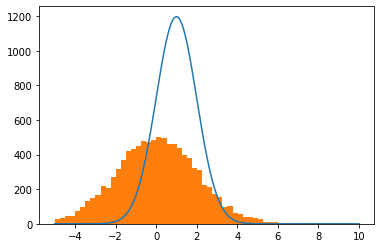

In [15]:
plot_model(gauss, data_normal)

## Different models

To create a more realistic model, we can build some components for a mass fit with a
- signal component: CrystalBall
- combinatorial background: Exponential
- partial reconstructed background on the left: Kernel Density Estimation

In [16]:
mass_obs = zfit.Space('mass', (0, 1000))

In [17]:
# Signal component

mu_sig = zfit.Parameter('mu_sig', 400, 100, 600)
sigma_sig = zfit.Parameter('sigma_sig', 50, 1, 100)
alpha_sig = zfit.Parameter('alpha_sig', 300, 100, 400)
n_sig = zfit.Parameter('n sig', 4, 0.1, 30)
signal = zfit.pdf.CrystalBall(obs=mass_obs, mu=mu_sig, sigma=sigma_sig, alpha=alpha_sig, n=n_sig)

In [18]:
# combinatorial background

lam = zfit.Parameter('lambda', -0.01, -0.05, -0.001)
comb_bkg = zfit.pdf.Exponential(lam, obs=mass_obs)

In [19]:
# partially reconstructed shape as a KDE

part_reco_data = np.random.normal(loc=200, scale=150, size=700)
part_reco_data = zfit.Data.from_numpy(obs=mass_obs, array=part_reco_data)  # we don't need to do this but now we're sure it's inside the limits

part_reco = zfit.pdf.GaussianKDE1DimV1(obs=mass_obs, data=part_reco_data, bandwidth='adaptive')

We can compose multiple models together. Here we will use a SumPDF. This takes pdfs and fractions. If we provide n pdfs and:
- n - 1 fracs: the nth fraction will be 1 - sum(fracs)
- n fracs: no normalization attempt is done by SumPDF. If the fracs are not implicitly normalized, this can lead to bad fitting behavior if there is a degree of freedom too much

In [20]:
sig_frac = zfit.Parameter('sig_frac', 0.3, 0, 1)
comb_bkg_frac = zfit.Parameter('comb_bkg_frac', 0.25, 0, 1)
model = zfit.pdf.SumPDF([signal, comb_bkg, part_reco], [sig_frac, comb_bkg_frac])

In order to have a corresponding data sample, we can just create one. Since we want to fit to this dataset later on, we will create it with slightly different values. Therefore, we can use the ability of a parameter to be set temporarily to a certain value with

In [21]:
with zfit.param.set_values([mu_sig, sigma_sig, sig_frac, comb_bkg_frac, lam], [370, 34, 0.18, 0.15, -0.006]):
    data = model.sample(n=10000)

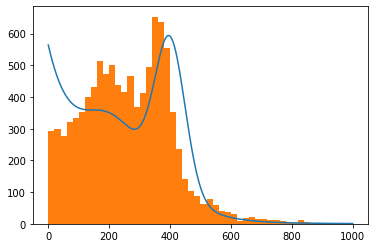

In [22]:
plot_model(model, data);

Plotting the components is not difficult now: we can either just plot the pdfs separately (as we still can access them) or in a generalized manner by accessing the pdfs attribute:

In [23]:
def plot_comp_model(model, data):
    for mod, frac in zip(model.pdfs, model.params.values()):
        plot_model(mod, data, scale=frac, plot_data=False)
    plot_model(model, data)

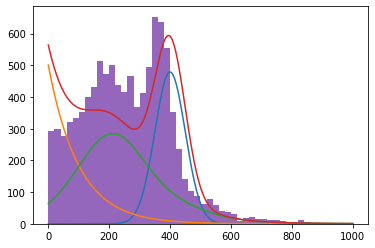

In [24]:
plot_comp_model(model, data)

## Fitting

So far we've looked only at normalized PDFs. In order to add information on the absolute scale, we need to *extend* the PDFs, just like one does in RooFit: We add a yield to it. This will **not** change the behaviour. What changes is that the flag `model.is_extended` now returns `True`. Furthermore, we have now a few more methods that we can use which would have raised an error before: `get_yield`, `ext_pdf` and `ext_integrate` (which will do the same thing as before - but multiplied by the yield).

In [25]:
sig_yield = zfit.Parameter('sig_yield', 2000, 0, 10000, step_size=1)
sig_ext = signal.create_extended(sig_yield)

comb_bkg_yield = zfit.Parameter('comb_bkg_yield', 6000, 0, 10000, step_size=1)
comb_bkg_ext = comb_bkg.create_extended(comb_bkg_yield)

part_reco_yield = zfit.Parameter('part_reco_yield', 2000, 0, 10000, step_size=1)
part_reco.set_yield(part_reco_yield)  # unfortunately, `create_extended` does not work here. But no problem, it won't change anyting.
part_reco_ext = part_reco

In [26]:
model_ext_sum = zfit.pdf.SumPDF([sig_ext, comb_bkg_ext, part_reco_ext])

A loss combines the model and the data, for example to build a likelihood. Furthermore, it can contain constraints, additions to the likelihood. Currently, if the Data has weights, these are automatically taken into account.

In [27]:
nll_gauss = zfit.loss.UnbinnedNLL(gauss, data_normal)
print(nll_gauss.value())

tf.Tensor(32342.702170819764, shape=(), dtype=float64)


We can access data and models (and possible constraints) through the loss:

In [28]:
print(nll_gauss.data)
print(nll_gauss.model)
print(nll_gauss.constraints)

[<zfit.Gauss  params=[mu, sigma42] dtype=float64>0]
[]


More interestingly, we can now build a loss for our composite sum model using the sampled data. Since we created an extended model, we can now also create an extended likelihood, taking into account a Poisson term to match the yield to the number of events.

In [29]:
nll = zfit.loss.ExtendedUnbinnedNLL(model_ext_sum, data)
nll.get_params()

OrderedSet([<zfit.Parameter 'sig_yield' floating=True value=2000>, <zfit.Parameter 'comb_bkg_yield' floating=True value=6000>, <zfit.Parameter 'part_reco_yield' floating=True value=2000>, <zfit.Parameter 'alpha_sig' floating=True value=300>, <zfit.Parameter 'mu_sig' floating=True value=400>, <zfit.Parameter 'n sig' floating=True value=4>, <zfit.Parameter 'sigma_sig' floating=True value=50>, <zfit.Parameter 'lambda' floating=True value=-0.01>])

While a loss is interesting, we usually want to minimize it. Therefore we can use the minimizers in zfit, most notably Minuit, a wrapper around the iminuit minimizer, implemented as a python package by scikit-hep [ https://github.com/scikit-hep/iminuit ].

Given that iminuit provides us with a very reliable and stable minimizer, it is usually recommended to use this. Others are implemented as well and could easily be wrapped, however, the convergence is usually not as stable.

Minuit has a few options:
- tolerance: the Estimated Distance to Minimum (EDM) criteria for convergence (default 1e-3)
- verbosity: between 0 and 10, 5 is normal, 7 is verbose, 10 is maximum
- use_minuit_grad: if True, uses the Minuit numerical gradient instead of the TensorFlow gradient. This is usually more stable for smaller fits; furthermore the TensorFlow gradient can (experience based) sometimes be wrong.

In [30]:
minimizer = zfit.minimize.Minuit(use_minuit_grad=True)

Before we get fitting though - perhaps we can constrain our model a bit further. Let's show you how easy it is to do such a thing in python.

Let's try to fix the exponential tail, by fitting only the right sideband:

In [31]:
values = z.unstack_x(data)
obs_right_tail = zfit.Space('mass', (700, 1000))
data_tail = zfit.Data.from_tensor(obs=obs_right_tail, tensor=values)
with comb_bkg.set_norm_range(obs_right_tail):
    nll_tail = zfit.loss.UnbinnedNLL(comb_bkg, data_tail)
    minimizer.minimize(nll_tail)

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 469.7                      │        Ncalls = 19 (19 total)        │
│ EDM = 7.14e-10 (Goal: 0.001)     │               up = 0.5               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘


Since now we know the value of the lambda parameter, we can fix it.

In [32]:
lam.floating = False
lam

<zfit.Parameter 'lambda' floating=False value=-0.008687>

### And now, let's perform our full fit.

In [33]:
result = minimizer.minimize(nll)

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -1.908e+04                 │       Ncalls = 170 (170 total)       │
│ EDM = 0.00079 (Goal: 0.001)      │               up = 0.5               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘


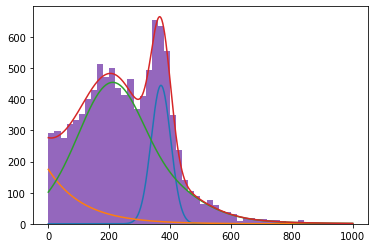

In [34]:
plot_comp_model(model_ext_sum, data)

In [35]:
print(result)

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.SumPDF  params=[Composed_autoparam_4, Composed_autoparam_5, Composed_autoparam_6] dtype=float64>0] data=[<zfit.core.data.SampleData object at 0x139e22700>] constraints=[]> 
with
<Minuit strategy=PushbackStrategy tolerance=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00079 │ -1.908e+04  │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name               value    at limit
---------------  -------  ----------
sig_yield           1799       False
comb_bkg_yield      1007       False
part_reco_yield     7197       False
alpha_sig            300       False
mu_sig             370.1       False
n sig                  4       False
sigma_sig          32.27       False


We can access the individual results as well

In [36]:
result.params[mu_sig]

{'value': 370.1287642185224}

'value' is the value at the minimum. To obtain other information about the minimization process, result contains more attributes:
- fmin: the function minimum
- edm: estimated distance to minimum
- info: contains a lot of information, especially the original information returned by a specific minimizer
- converged: if the fit converged

In [37]:
result.fmin

-19079.851182498693

In order to estimate the uncertainties, similar to fitting with RooFit, we have to invoke one of two methods available to us:
- a profile likelihood method (a la MINOS)
- a Hessian approximation of the likelihood (a la HESSE)

When using Minuit, this uses (currently) it's own implementation. However, zfit has its own implementation, which are likely to become the standard and can be invoked by changing the method name.

In [38]:
result.hesse()
# result.hesse(method='hesse_np')

OrderedDict([(<zfit.Parameter 'sig_yield' floating=True value=1799>,
              {'error': 67.47953053760388}),
             (<zfit.Parameter 'comb_bkg_yield' floating=True value=1007>,
              {'error': 63.5879163727162}),
             (<zfit.Parameter 'part_reco_yield' floating=True value=7197>,
              {'error': 106.9376664990839}),
             (<zfit.Parameter 'alpha_sig' floating=True value=300>,
              {'error': 141.4213562373095}),
             (<zfit.Parameter 'mu_sig' floating=True value=370.1>,
              {'error': 1.296048892670503}),
             (<zfit.Parameter 'n sig' floating=True value=4>,
              {'error': 10.069756698215553}),
             (<zfit.Parameter 'sigma_sig' floating=True value=32.27>,
              {'error': 1.2286707217998771})])

As a consequence, the result dict is filled with the errors on the parameters:

In [39]:
print(result.params)

name               value    minuit_hesse    at limit
---------------  -------  --------------  ----------
sig_yield           1799     +/-      67       False
comb_bkg_yield      1007     +/-      64       False
part_reco_yield     7197     +/- 1.1e+02       False
alpha_sig            300     +/- 1.4e+02       False
mu_sig             370.1     +/-     1.3       False
n sig                  4     +/-      10       False
sigma_sig          32.27     +/-     1.2       False


In [40]:
# (Now using MINOS)
errors, new_result = result.errors(params=[sig_yield, part_reco_yield, mu_sig])  # just using three for speed reasons
# errors, new_result = result.errors(params=[yield_model, sig_frac, mu_sig], method='zfit_error')

/usr/local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:358: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn("'minuit_minos' will be changed as the default errors method to a custom implementation"


In [41]:
print(result.params)

name               value    minuit_hesse         minuit_minos    at limit
---------------  -------  --------------  -------------------  ----------
sig_yield           1799     +/-      67  -     68   +     69       False
comb_bkg_yield      1007     +/-      64                            False
part_reco_yield     7197     +/- 1.1e+02  -1.3e+02   +1.2e+02       False
alpha_sig            300     +/- 1.4e+02                            False
mu_sig             370.1     +/-     1.3  -    1.3   +    1.3       False
n sig                  4     +/-      10                            False
sigma_sig          32.27     +/-     1.2                            False


And one can access the values via

In [42]:
print(f" mu_sig = {result.params[mu_sig]['value']} +- {result.params[mu_sig]['minuit_hesse']['error']}")

 mu_sig = 370.1287642185224 +- 1.296048892670503


In case you want to show off with some likelhood profiling, we can do that in a few lines as well:

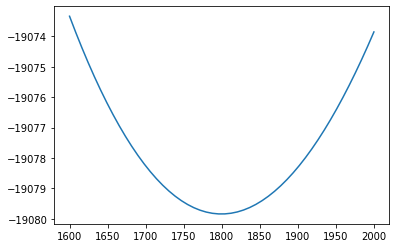

In [43]:
x = np.linspace(1600, 2000, num=50)
y = []
sig_yield.floating = False
for val in x:
    sig_yield.set_value(val)
    y.append(nll.value())

sig_yield.floating = True
zfit.param.set_values(nll.get_params(), result)

plt.plot(x, y)

And, obviously, the covariance matrix is also available:

In [44]:
result.covariance()

array([[ 4.55348704e+03,  7.08809328e+02, -3.14265313e+03,
         0.00000000e+00, -1.51754523e+01,  0.00000000e+00,
         3.73489907e+01],
       [ 7.08809328e+02,  4.04342311e+03, -3.81790584e+03,
         0.00000000e+00, -4.68353175e+00,  0.00000000e+00,
         1.05443876e+01],
       [-3.14265313e+03, -3.81790584e+03,  1.14356645e+04,
         0.00000000e+00,  2.43986505e+01,  0.00000000e+00,
        -4.44845349e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         2.00000000e+04,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.51754523e+01, -4.68353175e+00,  2.43986505e+01,
         0.00000000e+00,  1.67974273e+00,  0.00000000e+00,
        -2.29463390e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.01400000e+02,
         0.00000000e+00],
       [ 3.73489907e+01,  1.05443876e+01, -4.44845349e+01,
         0.00000000e+00, -2.29463390e-01,  0.00000000e+00,
         1.5096317